В данном файле показаны примеры построения траектории на разных картах с помощью базового решения (поиск на графе state lattice). 
Все карты задаются в виде строк (и считываются функцией convert_string_to_cells) и хранятся в памяти в виде бинарных матриц (это
обеспечивает класс Map). Так как нумерация строк в матрице производится сверху вниз, то аналогично считается $i$-координата рабочего
пространства. В таком случае, как уже обсуждалось, если хочется, чтобы траектория начиналась в угле $\theta_l$, достаточно заменить его 
углом $-\theta_l$ (аналогично и с финишным углом). 

In [1]:
import sys
import math
import time
from typing import List
sys.path.append("../common/")  # это позволяет делать import файла в параллельной папке common
from KC_structs import *
from KC_graphics import *
from KC_searching import *

### Дискретизация и примитивы движения

In [2]:
theta_16 = Theta()  # фиксируем дискретизацию
angle_num = theta_16.theta_amount  # количество углов
control_set = ControlSet(theta_16)  # инициализируем control set

prims_file = "main_control_set.txt"  # файл, где лежат примитивы

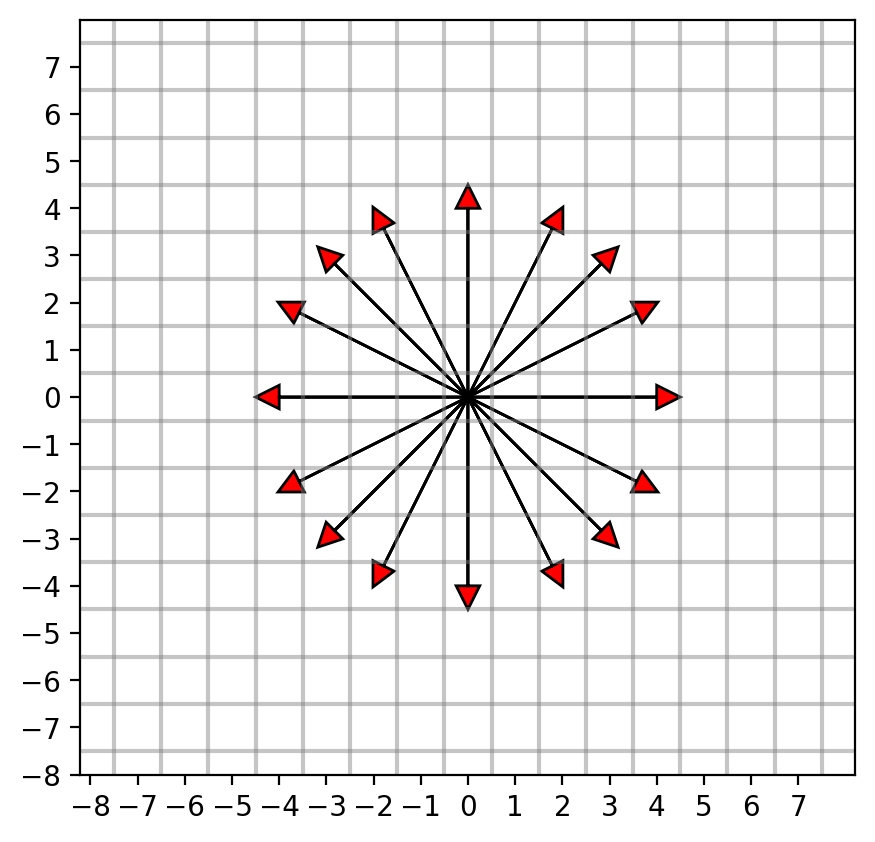

In [3]:
# рисуем дискретизацию
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
for i in range(16):
    plot_arrow(0, 0, theta_16[i], length=4, ax=ax)
draw_grid(ax)
plt.show()

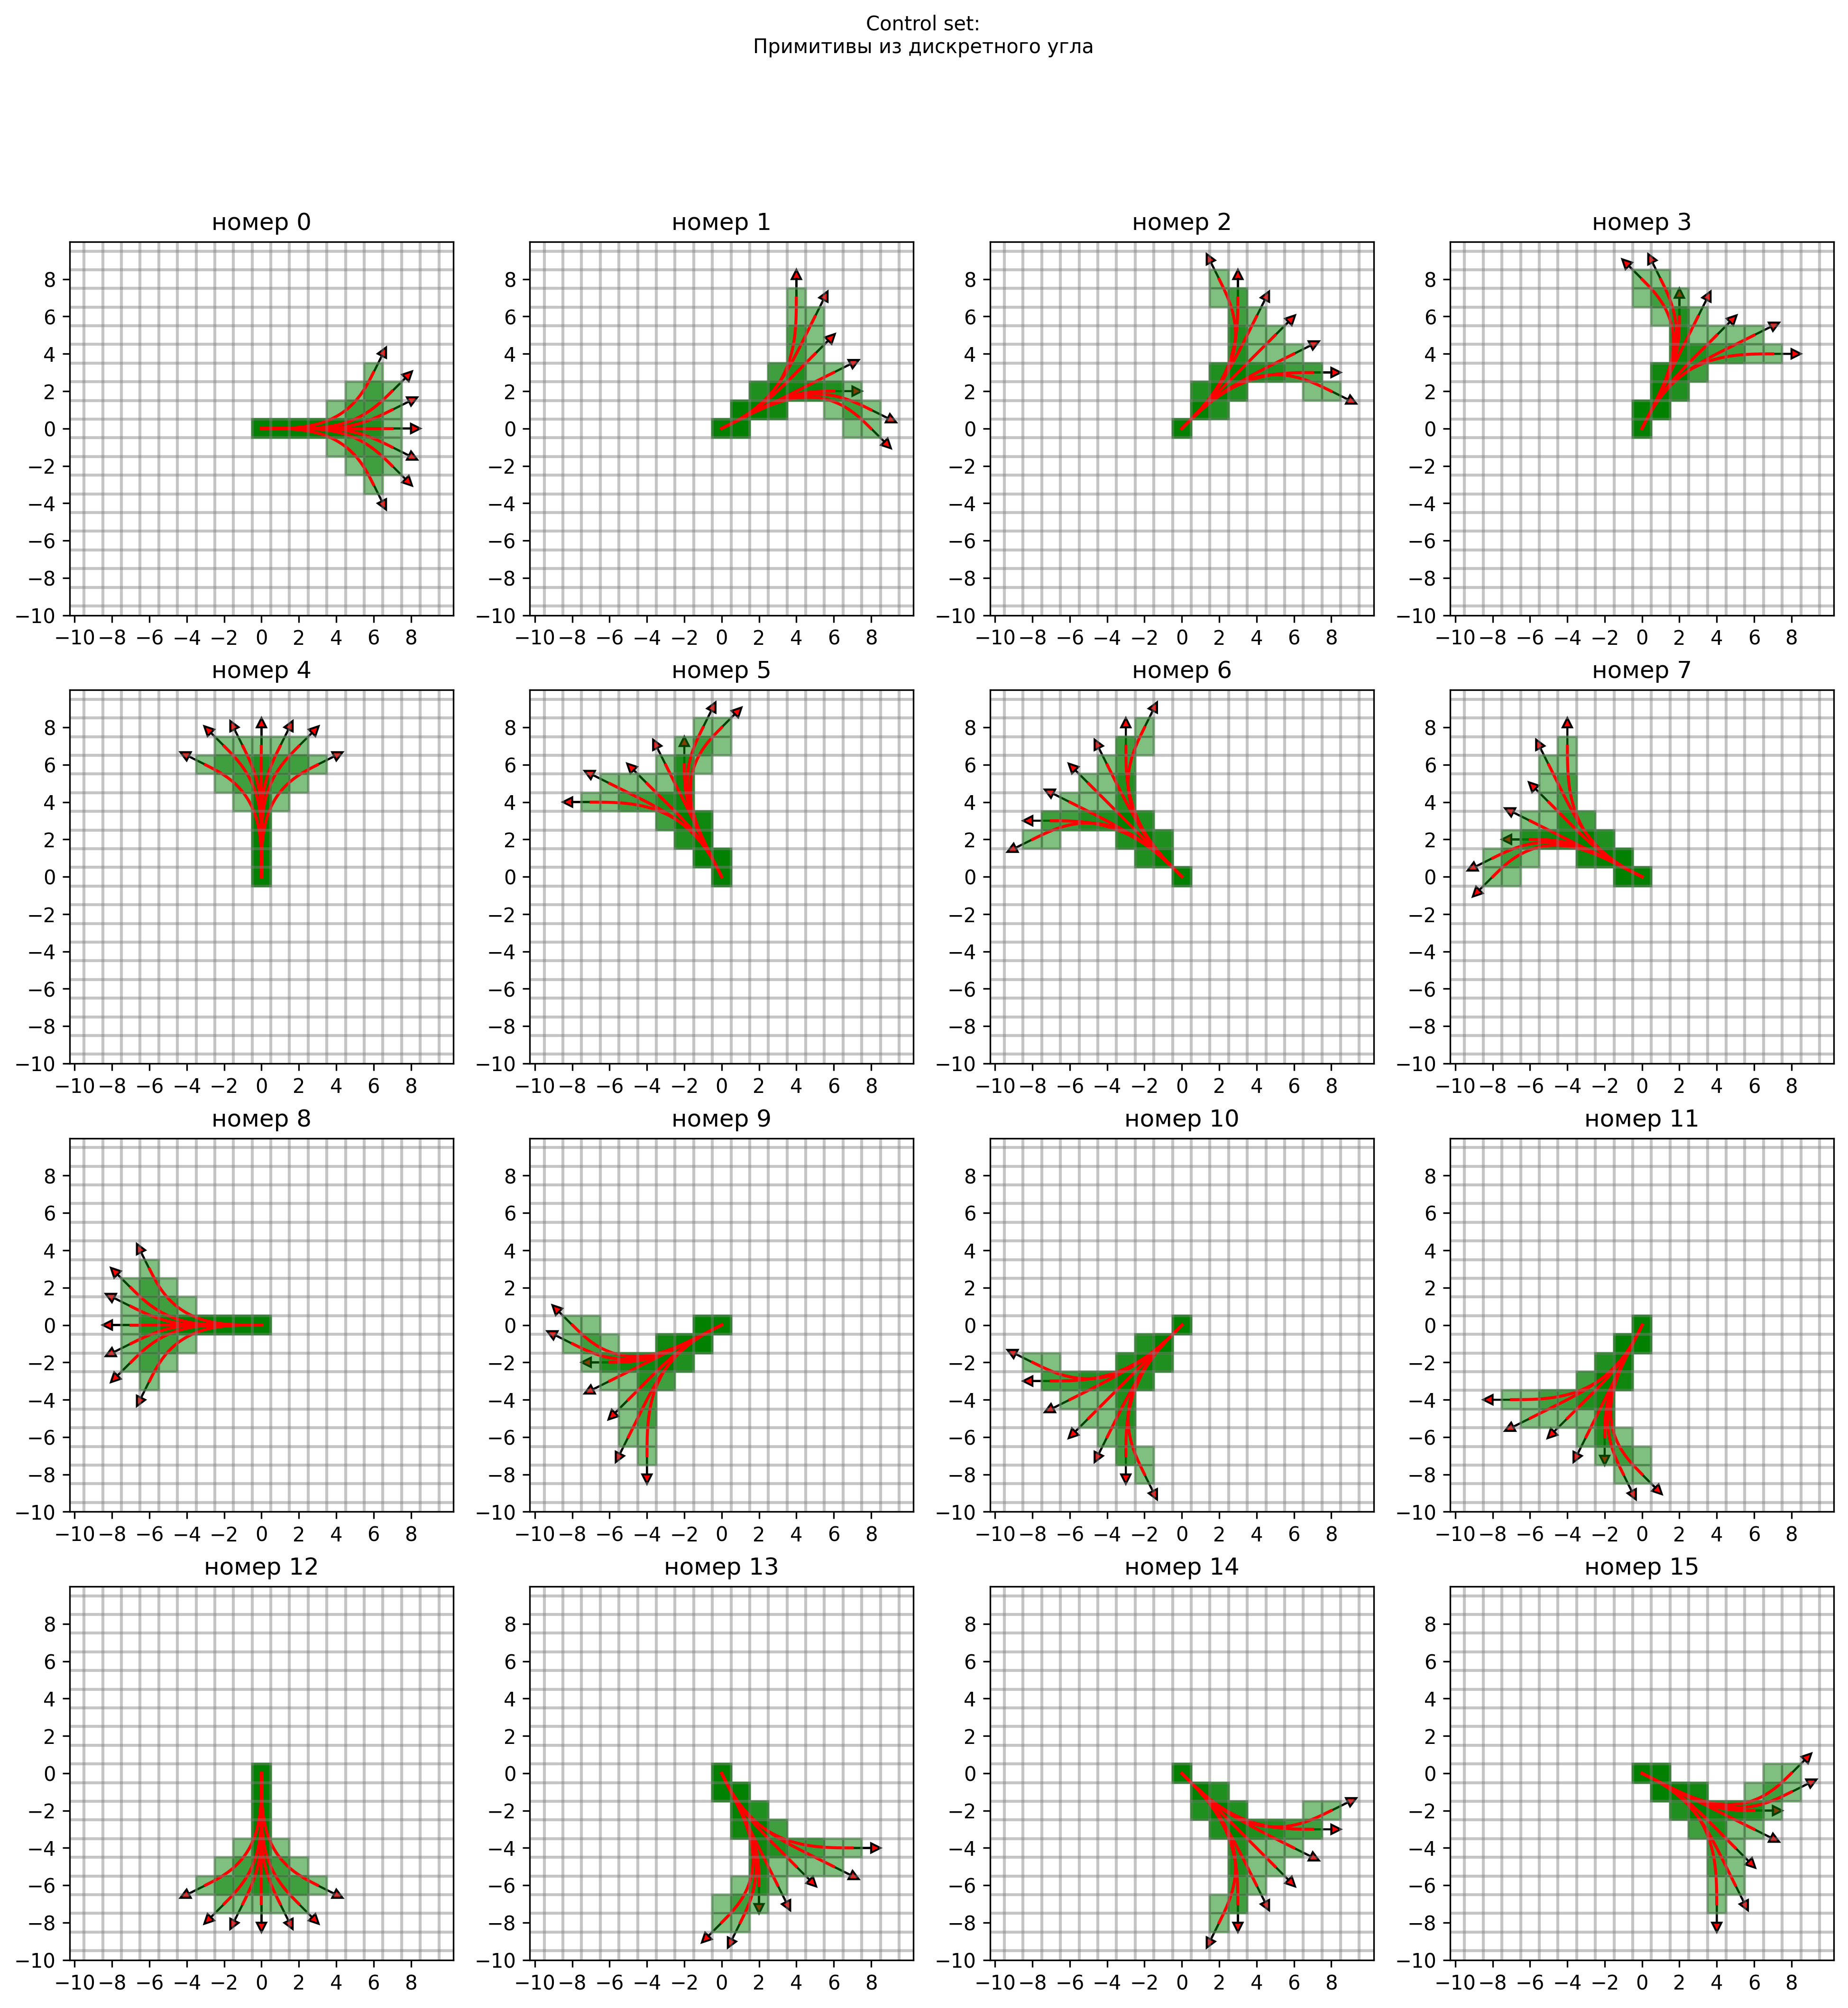

In [4]:
control_set.load_primitives(prims_file)  # загружаем примитивы

# отрисовываем все считанные примитивы (красные кривые) и их след (зелёные клетки) 
fig = plt.figure(figsize=(16, 16), dpi=300)
fig.suptitle(f"Control set:\nПримитивы из дискретного угла", fontsize=10)
for i in range(angle_num):
    ax = fig.add_subplot(angle_num // 4, 4, i+1, )
    ax.set_title(f"номер {i}")
    for prim in control_set.get_prims_heading(i):
        draw_primitive(prim, ax=ax, theta=theta_16)
        for i, j in zip(prim.collision_in_i, prim.collision_in_j):  # рисуем клеточки, через которое проходит примитив
            fig.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='g', alpha=0.5))
    draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2) 
    
#plt.savefig("imp111.png", transparent=False, facecolor='white')
plt.show()  

### Подготовка к поиску

Так как данный код реализует базовое решение, то в качестве вершин графа (которые обозначены как vertex в коде A*) выступают дискретные состояния (DiscreteState),
а самим графом будет state lattice. Для такого графа необходимо зафиксировать некоторые функции, которые будут определять поиск:
1. написать функцию get_successors, которая по вершине (дискретному состоянию) возвращает список её последователей.
2. определить функцию стоимости compute_cost, вычисляющую стоимость рёбер между парами вершин,
3. описать эвристическую функцию, которая по вершине выдаёт оценку минимального пути до любой целевой вершины
4. а также описать функцию is_goal, которая будет показывать, что поиск дошёл до целевой вершины и его можно останавливать.

Проще всего все эти функции сложить в единой структуре.

Замечание: в рамках данной реализации базового решения будем искать траектории относительно функционала качества - длина траектории. В качестве эвристики используем евклидово расстояние (и то, и то зафиксировано в структуре далее). Эта реализации генерирует результаты раздела 2.7 диплома.

In [5]:
class StateLatticeSearch:
    """
    Специальный класс, который описывает (настраивает) все необходимые функции для поиска через State Lattice.
    Смысл этого в том, чтобы максимально унифицировать алгоритмы. Алгоритм A*, структуры SearchTreePQD и SearchNode - едины
    для всего поиска (и на state lattice, и на графе типов, и на других графах) -> единственное, перед поиском нужно настроить
    такую структуру, где описать нужные функции (эвристику, стоимости) и тд. Аналогично будет работать и 
    с поиском на графе типов - там достаточно будет своей структуры, у которой будут такие же функции.
    """

    def __init__(self, task_map: Map, start: DiscreteState, finish: DiscreteState, control_set: ControlSet,
                 R: float = 3, A: int = 1) -> None:
        """
        Инициализация.

            task_map: карта, дискретное рабочее пространство, экземпляр Map(), где будет производиться поиск,
            start, finish: два дискретных состояния, откуда и до куда искать траекторию,
            control_set: набор примитивов, цепочкой которых будут получаться траектории (этот control_set создаёт state lattice),
            R, A: целевыми считаются все вершины, находящиеся в радиусе R от finish, и отличающиеся по направлению не более чем на A единиц.
        """

        self.task_map = task_map
        self.start = start
        self.finish = finish
        self.control_set = control_set
        
        self.R = R
        self.A = A


    def get_start_vertex(self) -> DiscreteState:
        """
        Данная функция должна вернуть вершину, с которой начинать поиск алгоритму A*. Так как в данном случае поиск
        производится на графе state lattice, то начальной вершиной будет само стартовое состояние (но вот в случае с поиском
        на графе типов нужно было бы сформировать соответствующую начальную ячейку).
        """

        return self.start
        

    def check_prim(self, i: int, j: int, prim: Primitive) -> bool:
        """
        Функция занимается проверкой коллизии с препятствиями: проверяем, что примитив prim из координат (i,j) не задевает препятствия.
        Важно, что примитив prim является элементом control set, поэтому он выходит из координат (0,0). В данной же 
        функции нужно проверить не сам prim, а ту его копию, которая выходит из (i,j) (так как все примитивы (= ребра state lattice)
        получается раскопированием исходного control set параллельным переносом - это называется регулярностью, см текст диплома).
    
            i,j: дискретные координаты,
            prim: примитив control_set, который параллельным переносом оказывается выходящим из (i,j).
        
        Замечание: Можно было бы в функцию подавать сразу копию примитива, который будет идти из координат (i,j), но для этого
        такой примитив нужно создать (выделить под него память и тд), что является напрасной тратой ресурсов. Гораздо проще
        иметь один фиксированный набор control set, а в рамках поиска использовать лишь примитивы из него (если нужно обозначить
        какой-то конкретный примитив (конкретное ребро state lattice), то так как он всё равно получен параллельным переносом какого-то
        примитива control set, гораздо экономнее использовать этот уже имеющийся примитив control set + ещё пару чисел (i,j), которые
        обозначают его параллельный перенос).
        """
        
        for i_coll, j_coll in zip(prim.collision_in_i, prim.collision_in_j):  # достаточно проверить, что клетки коллизионного следа не пересекают препятствий
            if not (self.task_map.in_bounds(i_coll+i, j_coll+j) and self.task_map.traversable(i_coll+i, j_coll+j)):  # не забываем каждую клетку сдвинуть на (i,j)
                return False
        return True
    

    def get_successors(self, state: DiscreteState) -> List[DiscreteState]:
        """
        Функция возвращает список последователей (в которые есть ребро на графе) вершины state.
    
            state: дискретное состояние, вершина графа state lattice - образец клааса DescreteState.
        """
        
        neighbors = []  # инициализируем список соседей вершины state
        for prim in self.control_set.get_prims_heading(state.theta):  # перебираем примитивы control set, выходящие под углом состояния state -
                                                                      # эти примитивы (если их параллельным переносом подвинуть в координаты start.i, start.j) 
                                                                      # являются рёбрами графа state lattice, выходящими из state (так как граф state lattice 
                                                                      # получается так, что примитивы control set раскопируются параллельным переносом по всем состояниям)
            if self.check_prim(state.i, state.j, prim):  # если у ребра нет коллизии с препятствиями, то оно ведёт в последователя state
                neighbors.append(DiscreteState(state.i+prim.goal.i,  # формируем последователя: целевое состояние примитива, подвинутого параллельным переносом в start
                                               state.j+prim.goal.j,
                                               prim.goal.theta))  # добавляем соседа

        return neighbors  # возвращаем список соседей


    def compute_cost(self, state1: DiscreteState, state2: DiscreteState) -> float:
        """
        Функция вычисляет стоимость ребра из состояния state1 в state2 на графе state lattice.

            state1, state2: состояния, между которыми (из первого во второе) есть ребро.
        """

        prim = self.control_set.get_prim_between_states(state1, state2)  # получаем примитив из первого состояния во второе (если его нет, значит ребра между вершинами нет -> некорректные входные данные)
        return prim.length  # в качестве стоимости берём самое простое - длину примитива (то есть ищем траекторию на state lattice наиболее 
                            # предпочтительную относительно функционала оценки качества траектории = длина траектории) -> ищем самую короткую траекторию на state lattice.


    def heuristic_func(self, state: DiscreteState) -> float:
        """
        Функция вычисляет значение эвристики (h-значение) для вершины state.

            state: вершина (состояние), экземпляр DescreteState
        """

        return math.sqrt((state.i - self.finish.i) ** 2 + (state.j - self.finish.j) ** 2)  # берём евклидово расстояние до финиша в качестве эвристики - оценки минимального пути


    def is_goal(self, state: DiscreteState) -> bool:
        """
        Функция по вершине возвращает, является ли она целевой - нужно ли на ней прекратить поиск.

            state: вершина (состояние), экземпляр DescreteState.
        """
        
        if ((math.sqrt((state.i - self.finish.i) ** 2 + (state.j - self.finish.j) ** 2) <= self.R) and  # если вершина удалена от финиша не более, чем на R
           (self.control_set.theta.num_dist(state.theta, self.finish.theta) <= self.A)):  # и её дискретный угол отличается от финиша не более, чем A
            return True  # вершина целевая
        else:
            return False

Если хочется что-то изменить в поиске (например, использовать другую эвристику, или изменить способ определения целевой вершины (не в круге радиуса R, а в квадрате со стороной R) или ещё что-то), то достаточно изменить эту структуру, не нужно менять файлы с кодом алгоритма A* или что-то ещё! Это очень удобно: одна структура настраивает весь поиск!

Если формальнее, сама структура (код класса StateLatticeSearch) настраивает поиск: как искать, на каком графе искать, какими функциями пользоваться и тд. А вот экземпляр этого класса (в который уже передали конкретную стартовую вершину, конкретный control set) уже фиксирует, что именно искать. Таким образом, сначала необходимо настроить поиск, а затем (это приведено далее) просто создавать конкретные экземпляры класса и с их помощью искать то, что нужно.

С поиском на графе типов будет аналогично: код A* и другие алгоритмы не поменяются, достаточно будет написать свою структуру (со своими функциями стоимости, эвристикой и тд), которая настроит поиск на граф типов. А затем просто создавать экземпляры с поданными на вход стартом и финишом для поиска.

### Общая функция визуализации и запуска построения пути

In [17]:
def make_path(search_params: StateLatticeSearch, 
              show: bool = True, file: str = None, dpi: int = 200, scale: float = 1.0):
    """
    Данная функция запускает алгоритм A*, находит путь (траекторию), отрисовывает результат (карту, траекторию,
    цель, старт и тд). А также замеряет время работы.

        search_params: экземпляр класса StateLatticeSearch, в котором уже хранится всё необходимое для поиска (дискретная карта,
                             начальные и конечные вершины (в данном случае - дискретные состояния), между которыми искать путь, и тд)
        show: нужно ли рисовать картинку,
        file: указать, если нужно сохранить картинку в файл,
        dpi: разрешение картинки,
        scale: масштаб картинки (увеличить, если хочется более огромную картинку)
    """
    
    t0 = time.time()
    result = astar(search_params.get_start_vertex(), search_params.is_goal, search_params.get_successors,
                   search_params.heuristic_func, search_params.compute_cost)  # запустили алгоритм A* со всеми настройками
    dur = time.time() - t0
    print(f"На поиск пути затрачено время: {dur} секунд")
        
    if not result[0]:
        print("Путь не найден!!!")
        return result
    else:
        print("Путь найден!")
        # выводим стоимость пути - она, очевидно, равна g-значению финальной вершины
        print(f"Стоимость пути равна {result[1].g}, финальное состояние: ({result[1].vertex.i} {result[1].vertex.j} {result[1].vertex.theta})")

    if show:
        # рисуем карту:
        ax = draw_task_map(search_params.task_map, search_params.start, search_params.finish,
                           dpi=dpi, scale=scale, A=search_params.A, R=search_params.R, theta=search_params.control_set.theta)
        
        # ===== рисуем примитивы, а точнее весь путь как цепочку из них =====
        path_prims = []
        current = result[1]  # последняя Search Node поиска
        while current.parent is not None:  # важно проверять через is not, так как для != будет использоваться функция __eq__
            prim = search_params.control_set.get_prim_between_states(current.parent.vertex, current.vertex)  # находим примитив, который ведет в текущую вершину из предыдущей
            draw_primitive(prim, ax=ax)  # просто рисуем примитив 
                                  # (ничего переворачивать не надо, так как это просто примитив, единственное - изменилось направление оси y)
            current = current.parent  # переходим к родителю
    
        if file:  # можно сохранить в файл
             plt.savefig(file, transparent=False, facecolor='white')
            
        plt.show()
        
    return result

### Примеры работы базового решения

На поиск пути затрачено время: 0.013482093811035156 секунд
Путь найден!
Стоимость пути равна 27.843319964394574, финальное состояние: (11 27 1)


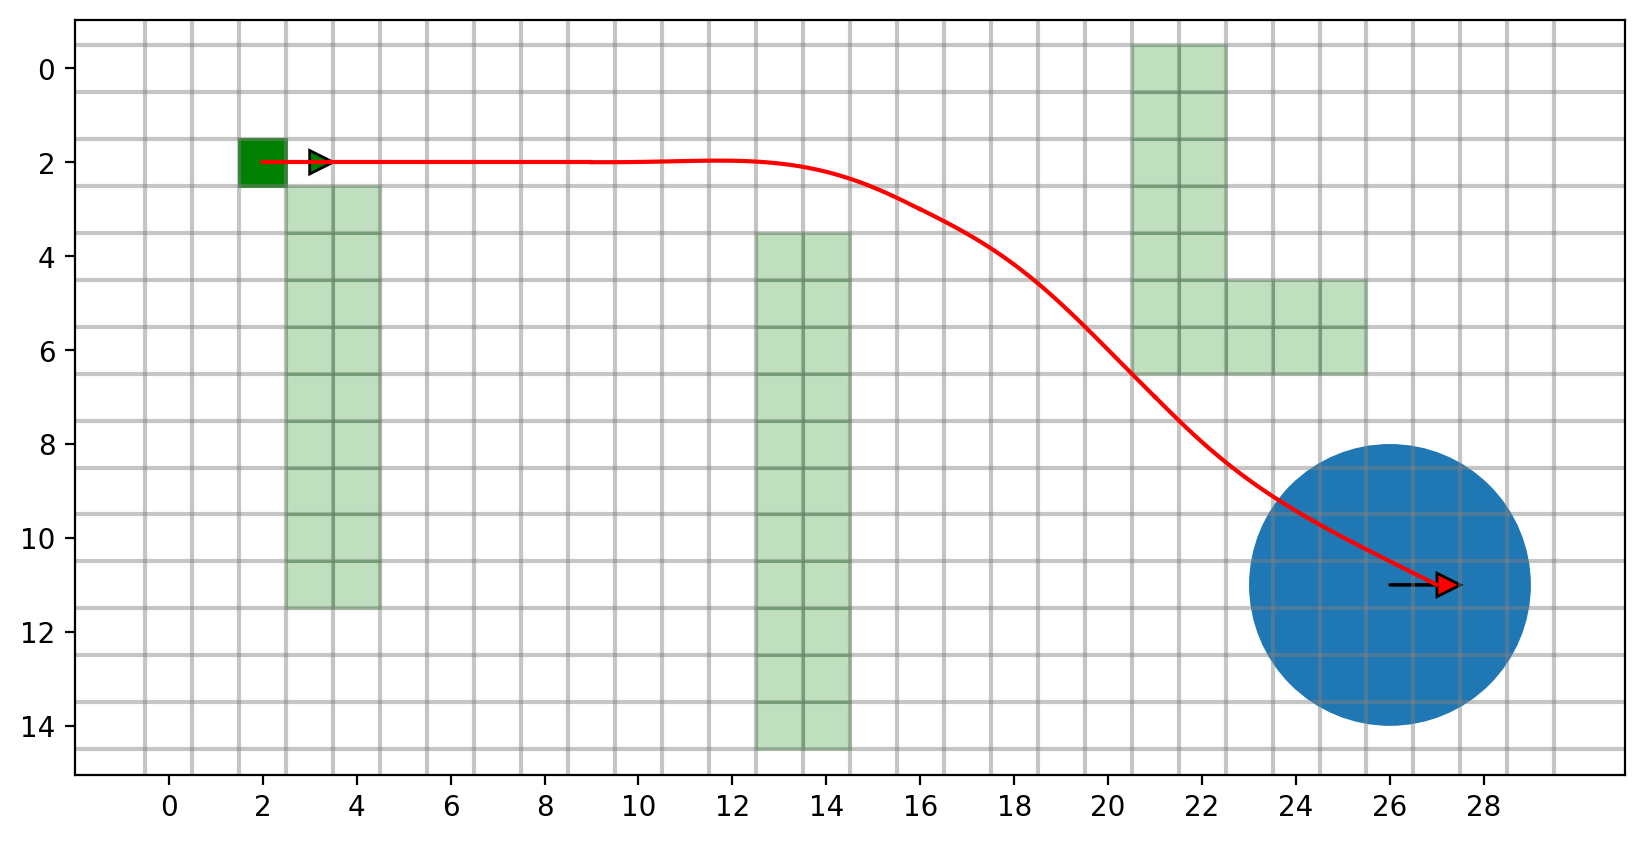

In [7]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''  # задали карту как строку (. - свободные клетки, # - препятствия)

task_map = Map().convert_string_to_cells(map_str, obs=True)  # считали карту
start = DiscreteState(2, 2, -0)  # задали состояния (углы пишем со знаком -, так как ось i направлена вниз, а не вверх как обычно при генерации примитивов)
goal = DiscreteState(11, 26, -0)
params = StateLatticeSearch(task_map, start, goal, control_set)  # собираем всё вместе в структуру

#res = make_path(params, file="ex_baseline_1.png", dpi=600)
res = make_path(params)  # запускаем поиск

На поиск пути затрачено время: 0.0 секунд
Путь найден!
Стоимость пути равна 34.56727821124493, финальное состояние: (12 25 1)


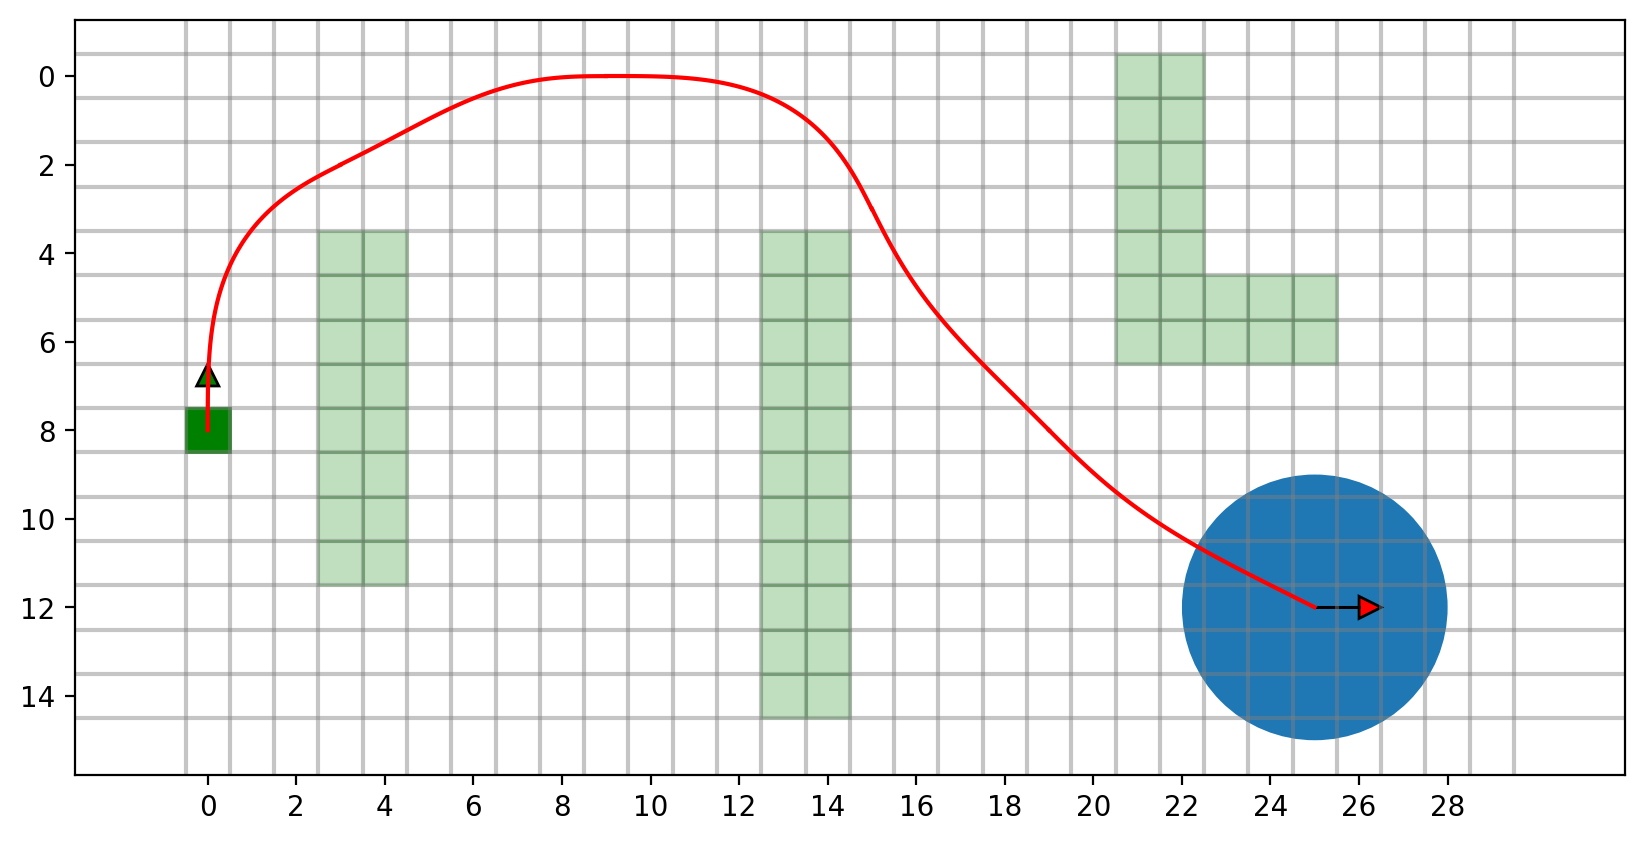

In [8]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(8, 0, -4)  # Так как в дискретной карте ось i перевёрнута, указываем углы с "-" (уже обсуждалось в коде генерации примитивов)
goal = DiscreteState(12, 25, -0)
params = StateLatticeSearch(task_map, start, goal, control_set)

#res = make_path(params, file="ex_baseline_2.png", dpi=600)
res = make_path(params)

На поиск пути затрачено время: 2.1303539276123047 секунд
Путь найден!
Стоимость пути равна 81.3755211478408, финальное состояние: (52 50 8)


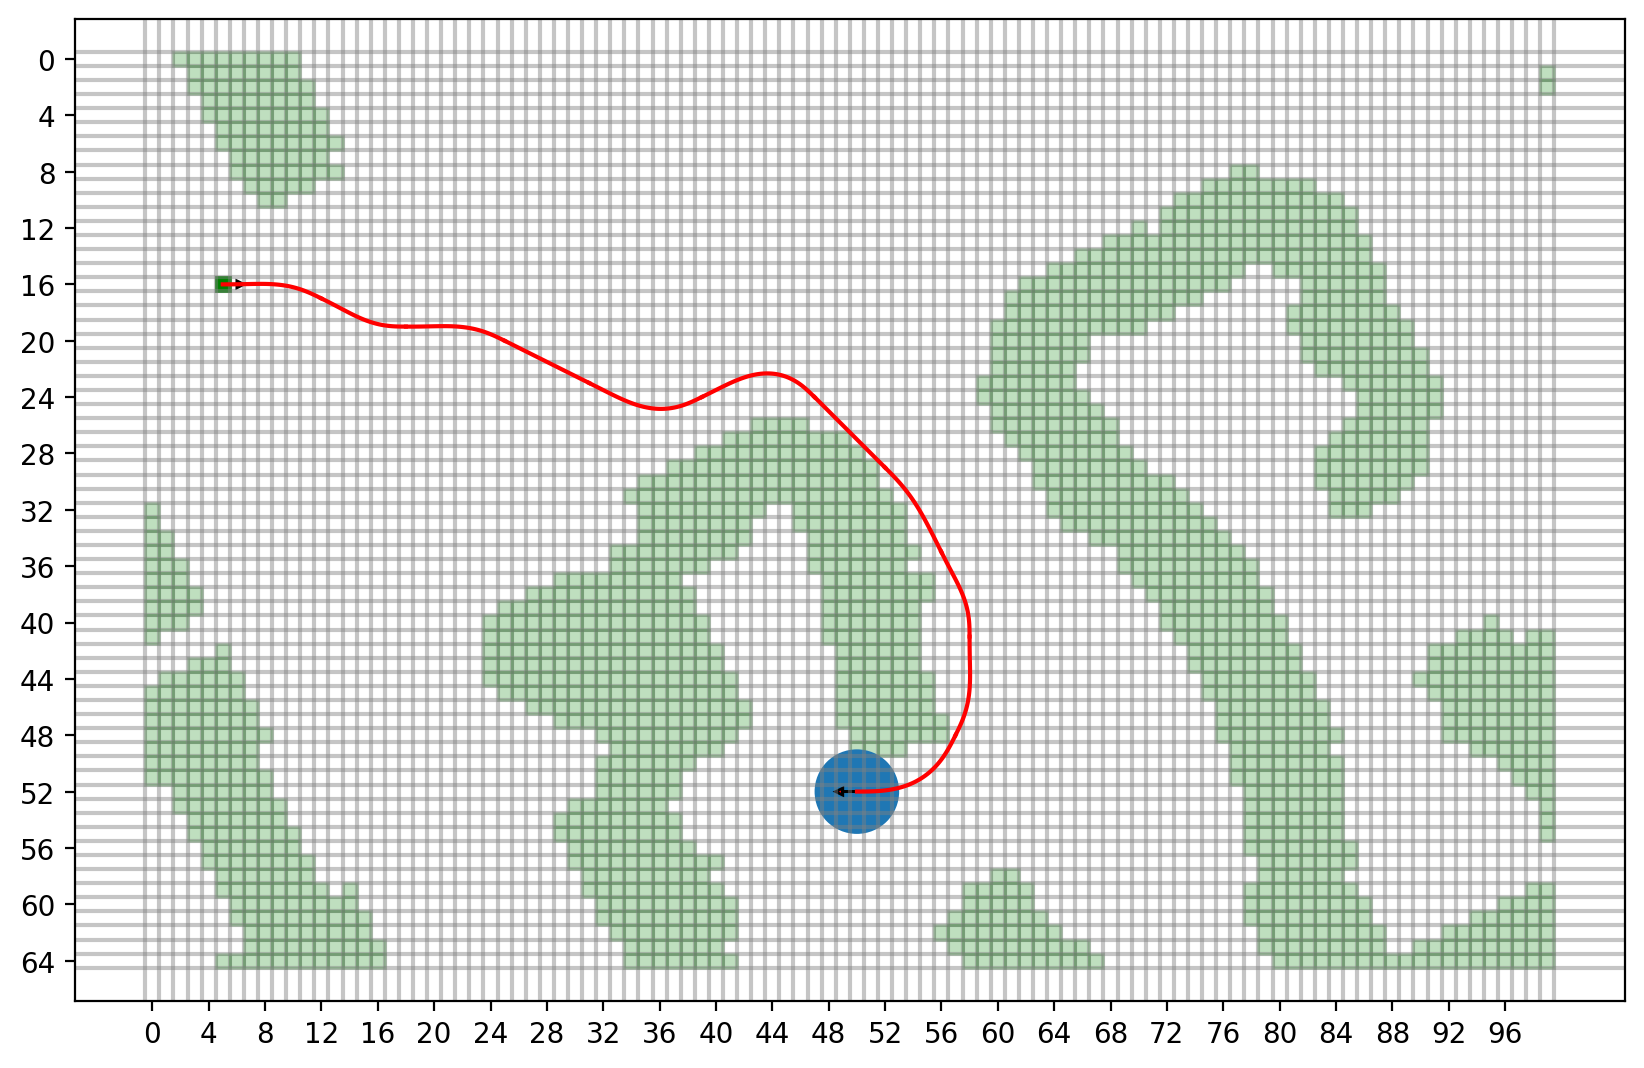

In [9]:
with open("Berlin_256.txt", "r") as f:  # берём карту из коллекции MovingAI
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)  # берём срез этой карты, так как она очень большая
start = DiscreteState(16, 5, -0)
goal = DiscreteState(52, 50, -8)
params = StateLatticeSearch(task_map, start, goal, control_set)

#res = make_path(params, file="ex_baseline_3.png", dpi=600)
res = make_path(params)

На поиск пути затрачено время: 6.351434946060181 секунд
Путь найден!
Стоимость пути равна 131.04810158601748, финальное состояние: (54 92 4)


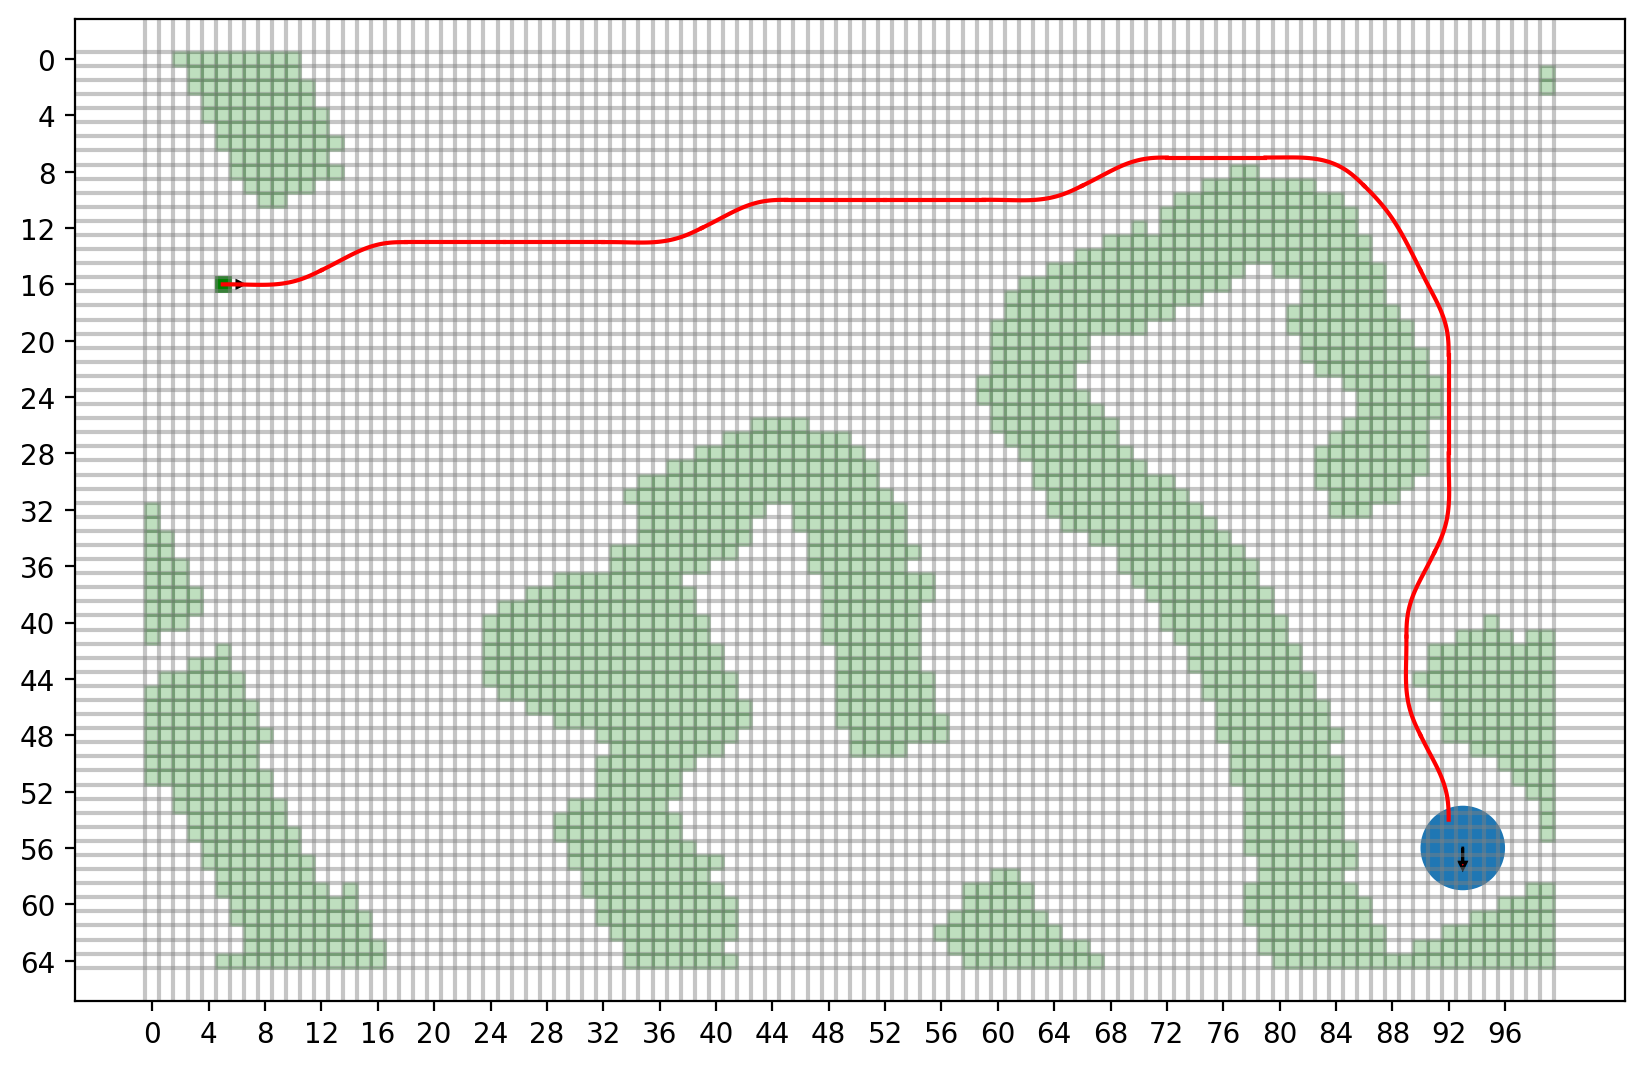

In [10]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(56, 93, -12)
params = StateLatticeSearch(task_map, start, goal, control_set)

res = make_path(params)

На поиск пути затрачено время: 12.336523056030273 секунд
Путь найден!
Стоимость пути равна 238.43935933652799, финальное состояние: (28 231 13)


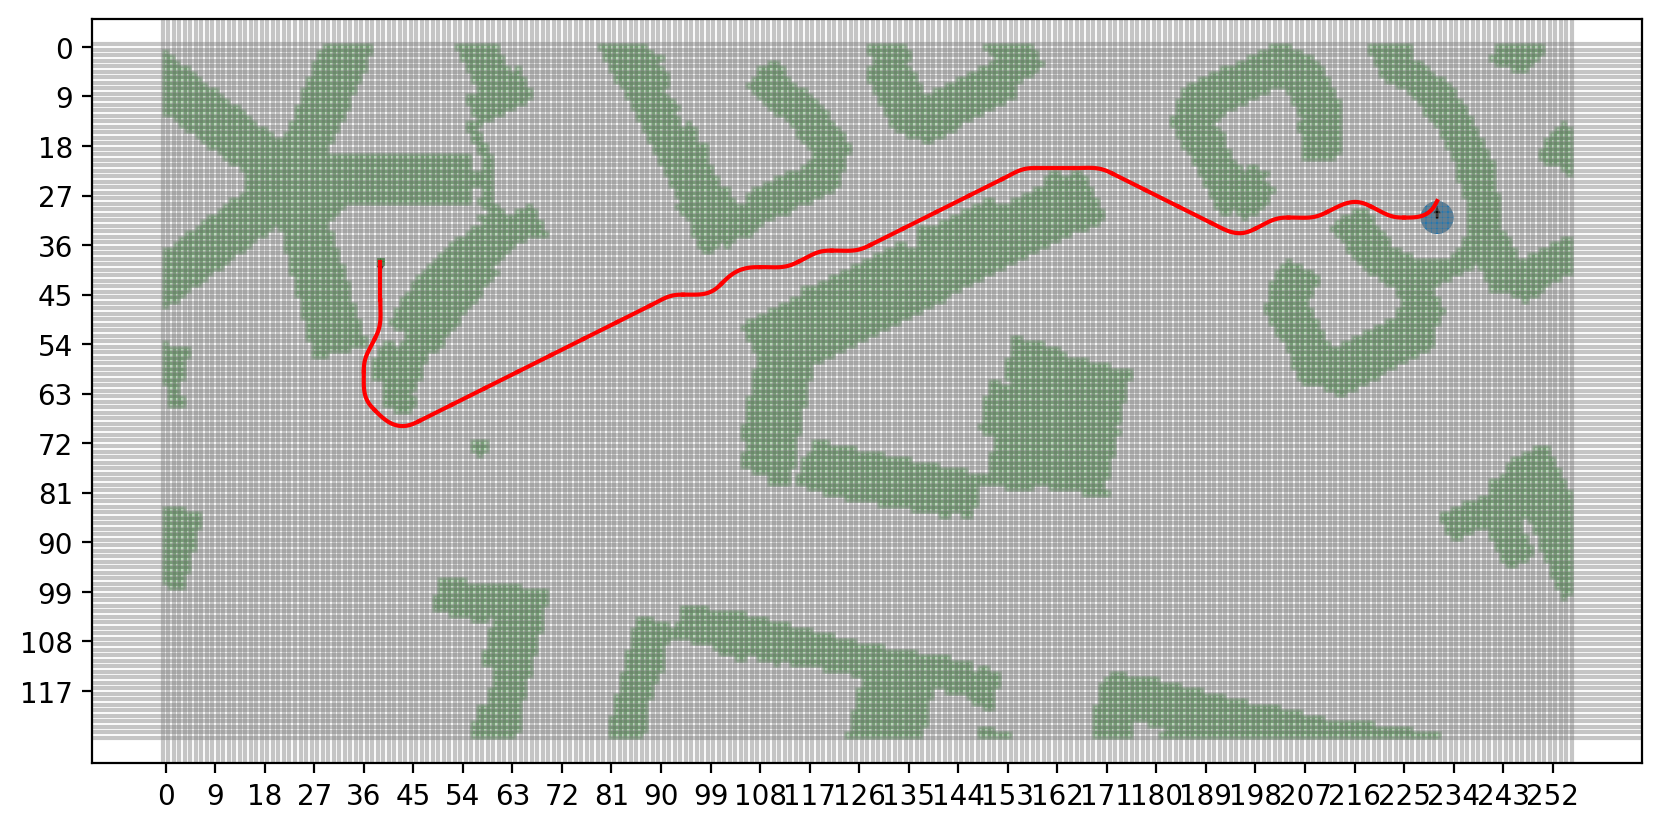

In [11]:
with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(80,-50,0,1000)  # 1000 - то есть всё что есть берём (очень большое число, чтобы точно вся карта влезла)
start = DiscreteState(39, 39, -12)
goal = DiscreteState(31, 231, -4)
params = StateLatticeSearch(task_map, start, goal, control_set)

#res = make_path(params, file="ex_baseline_4.png", dpi=600)
res = make_path(params)

### Посмотрим также на примеры поиска на этих же картах, но с другими control set:

In [12]:
# считываем два других сгенерированных раньше наборов примитивов:
short_control_set = ControlSet(theta_16).load_primitives("short_control_set.txt")
big_control_set = ControlSet(theta_16).load_primitives("big_control_set.txt")

На поиск пути затрачено время: 0.027031660079956055 секунд
Путь найден!
Стоимость пути равна 25.42385174471612, финальное состояние: (10 25 1)


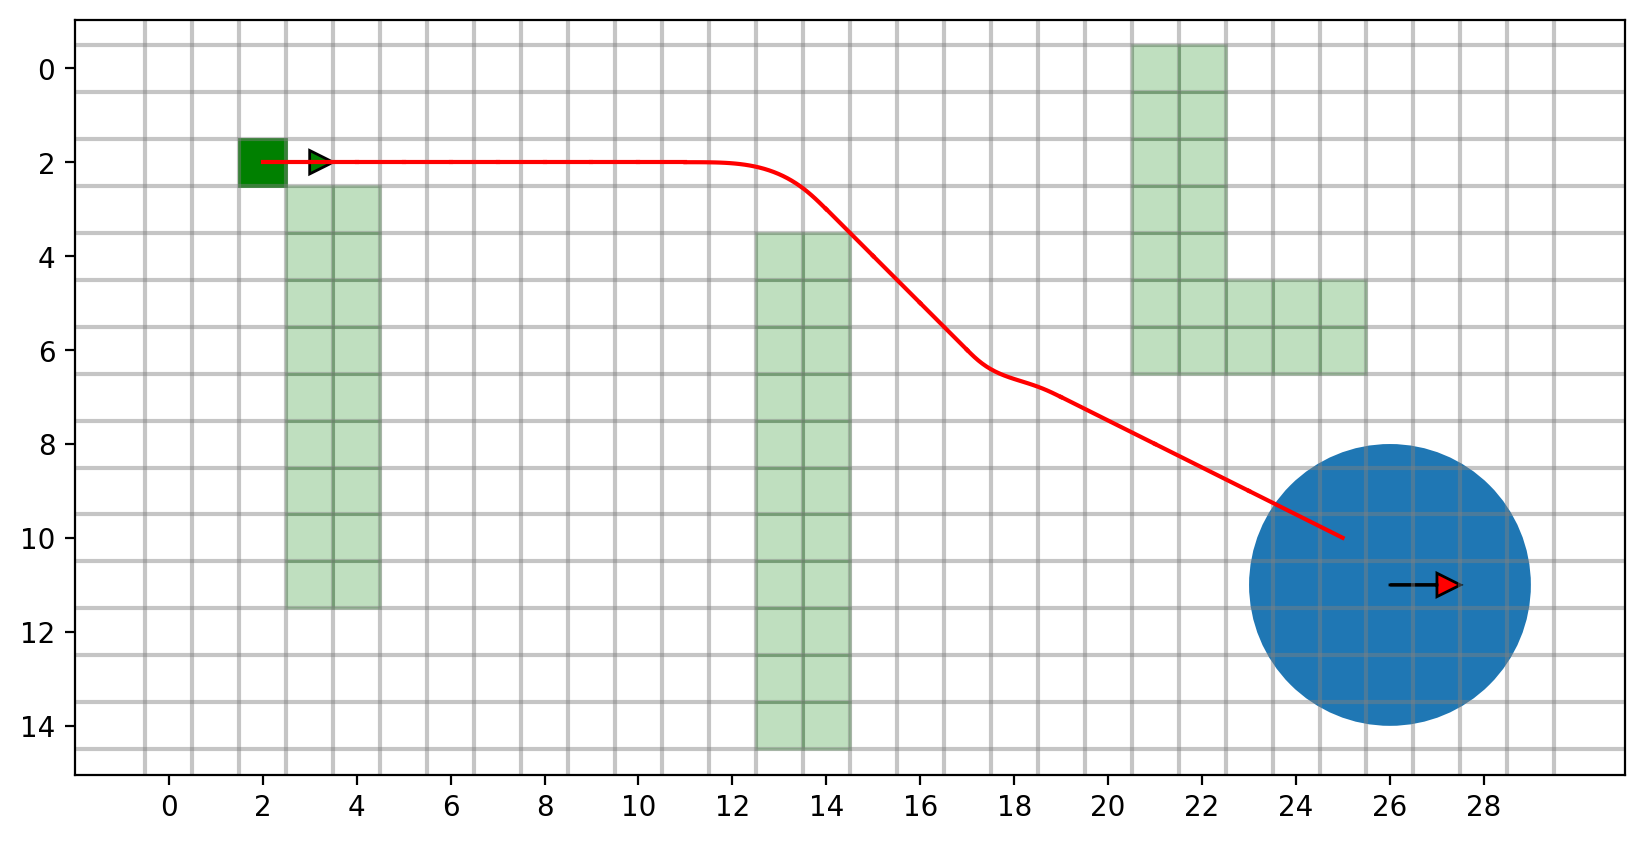

In [13]:
# возьмём самый первый пример:

map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
''' 

task_map = Map().convert_string_to_cells(map_str, obs=True)  # карта, начальное и финишное состояния не поменялись
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)

params = StateLatticeSearch(task_map, start, goal, short_control_set)  # единственное, что изменилось - используем другой control-set
res = make_path(params) 

На поиск пути затрачено время: 0.03991508483886719 секунд
Путь найден!
Стоимость пути равна 26.67159970209402, финальное состояние: (11 26 1)


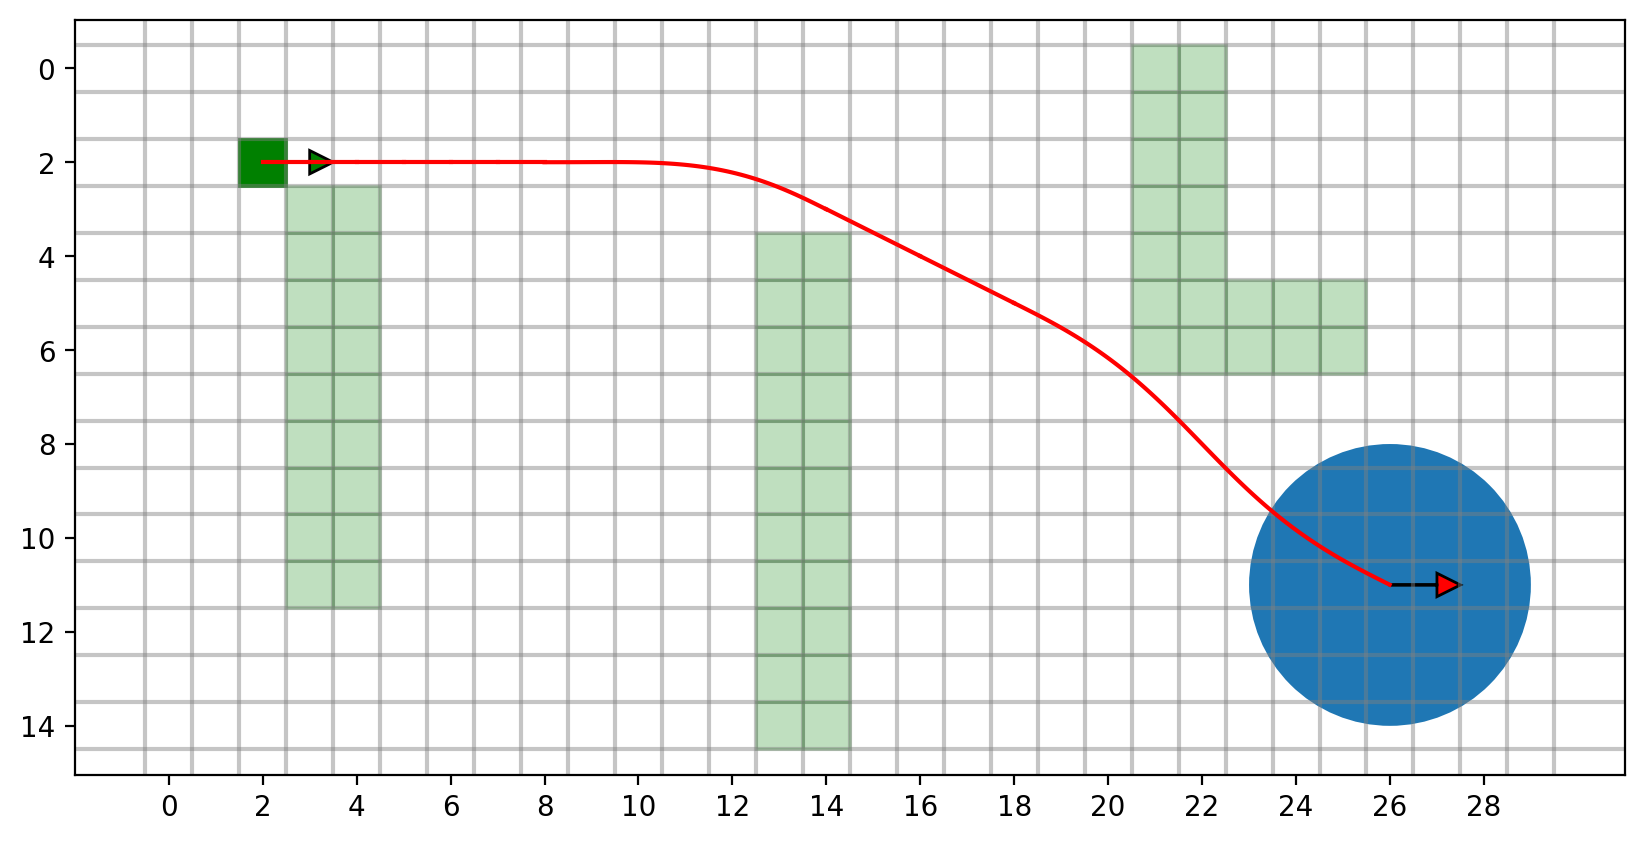

In [14]:
map_str =\
'''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
''' 

task_map = Map().convert_string_to_cells(map_str, obs=True)
start = DiscreteState(2, 2, -0)
goal = DiscreteState(11, 26, -0)

params = StateLatticeSearch(task_map, start, goal, big_control_set)  # теперь большой control-set
res = make_path(params) 

На поиск пути затрачено время: 9.788664817810059 секунд
Путь найден!
Стоимость пути равна 129.15374794529313, финальное состояние: (53 93 4)


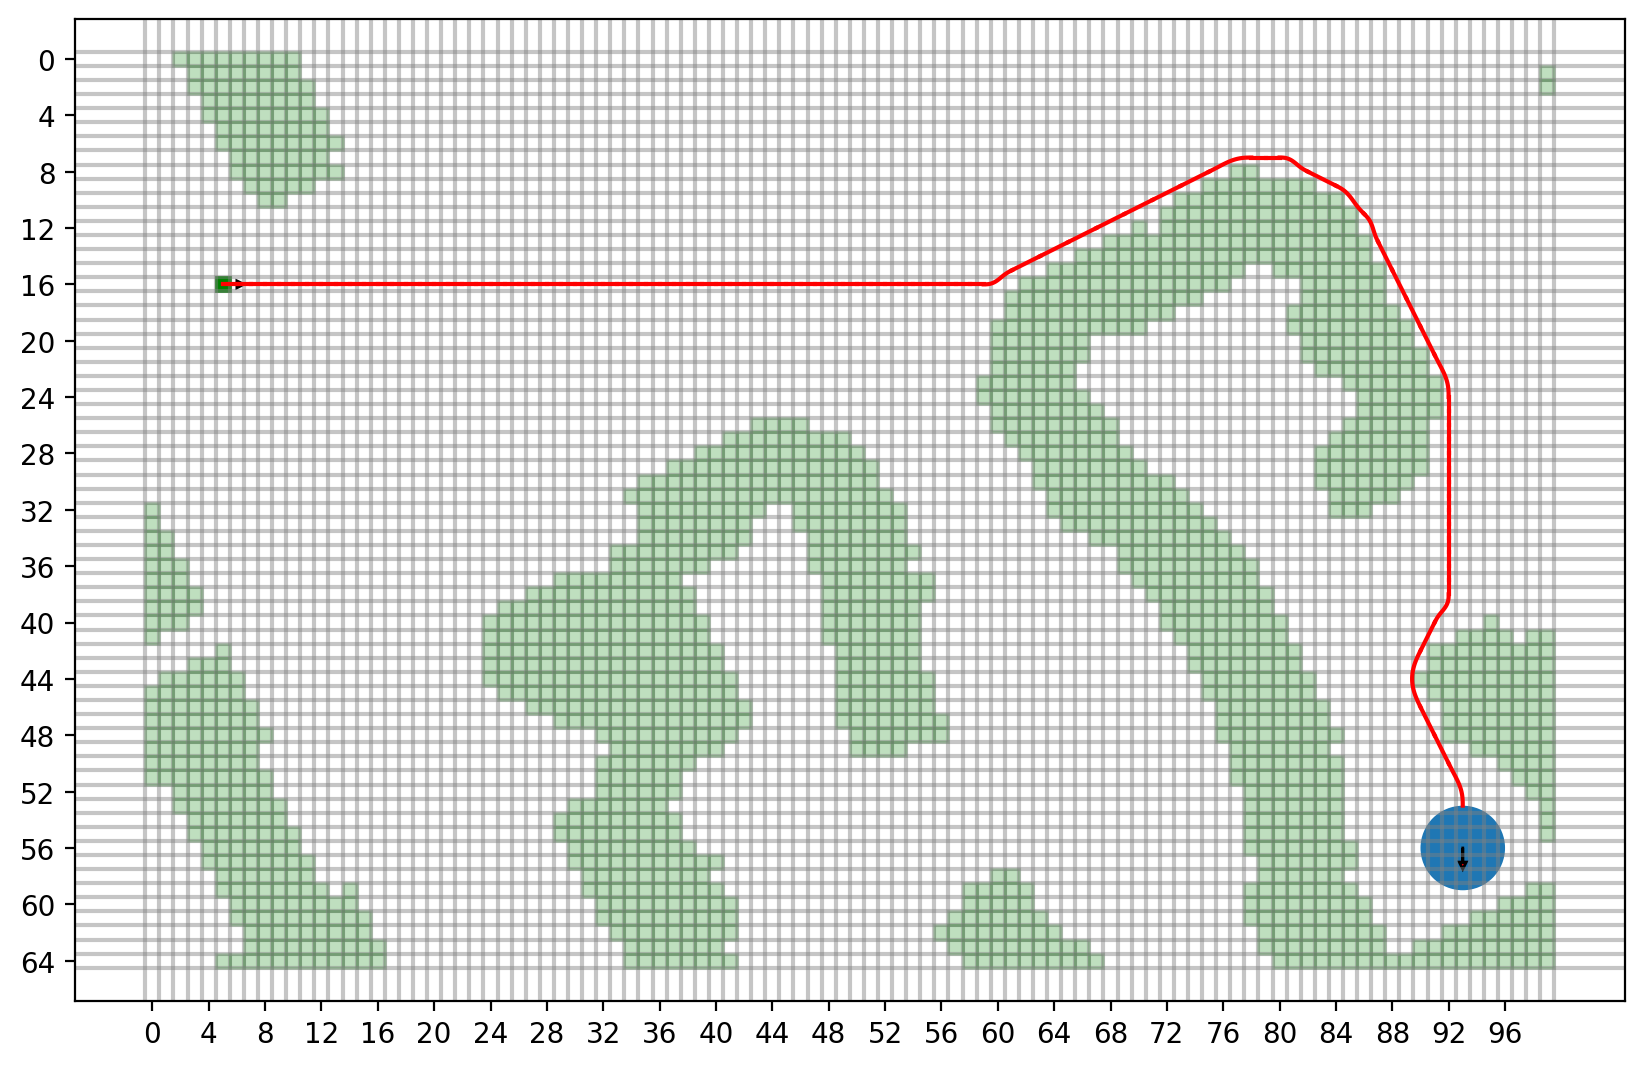

In [15]:
# предпоследний пример

with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(56, 93, -12)
params = StateLatticeSearch(task_map, start, goal, short_control_set)

res = make_path(params)

На поиск пути затрачено время: 22.16874623298645 секунд
Путь найден!
Стоимость пути равна 131.71884611626018, финальное состояние: (56 93 4)


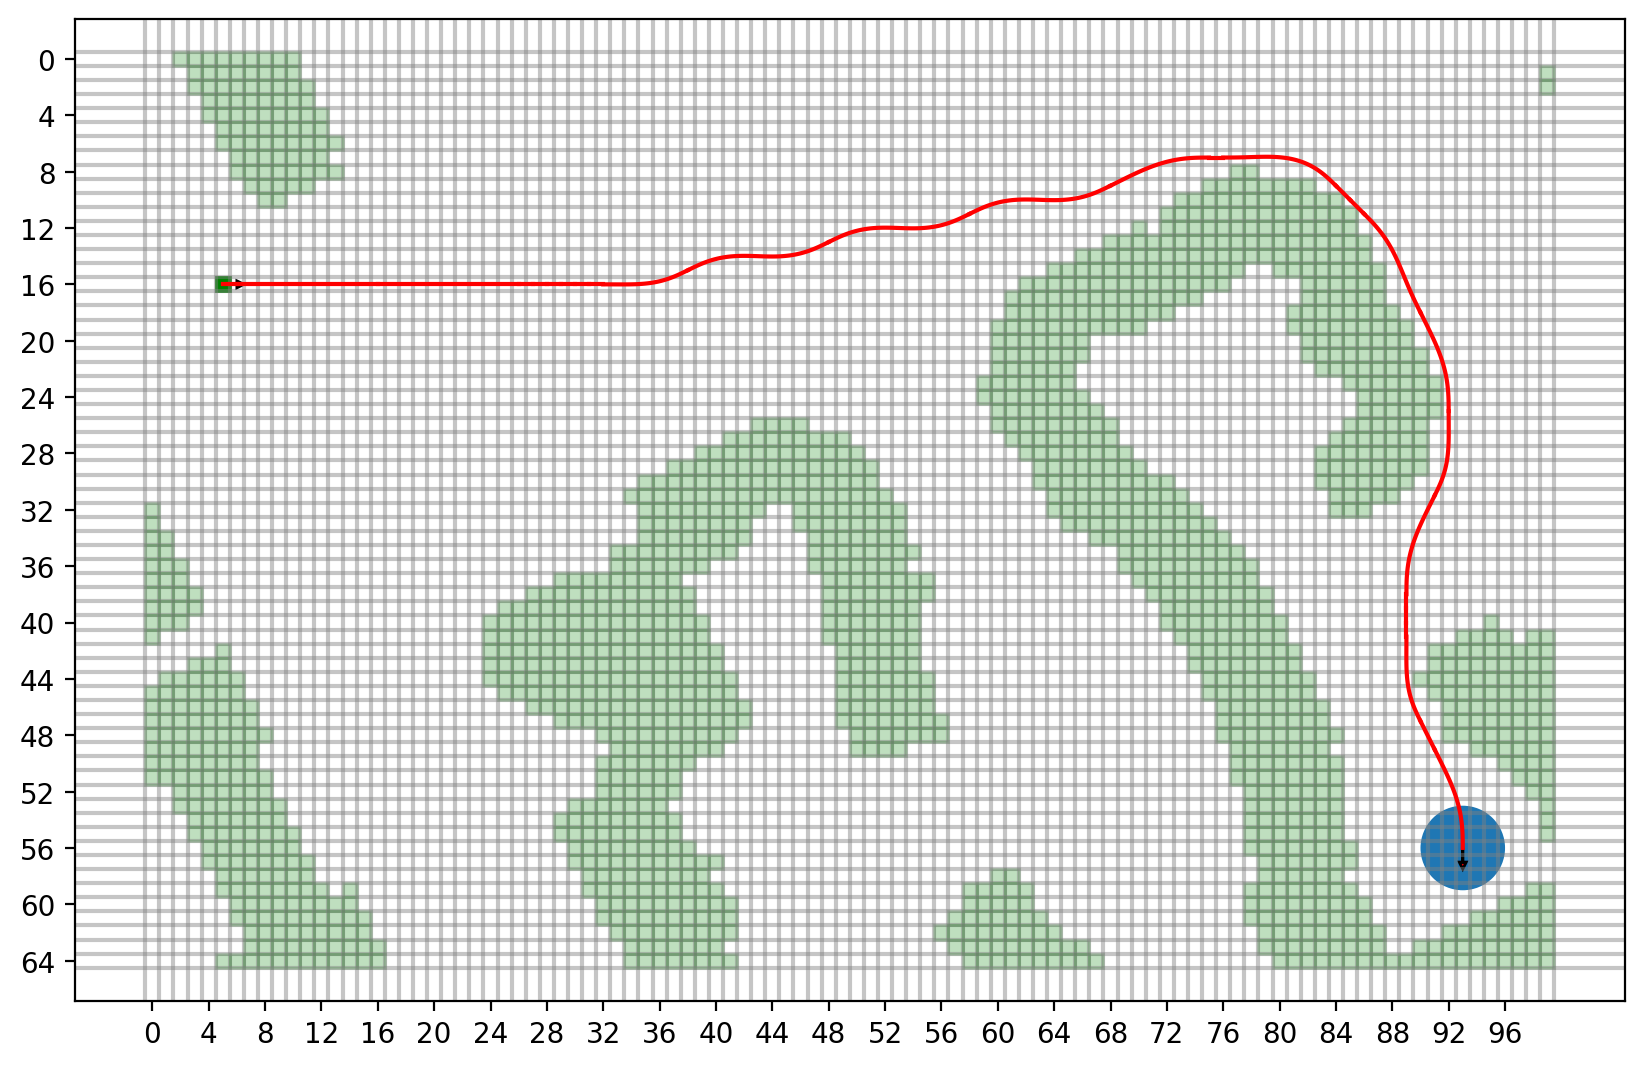

In [16]:
# предпоследний пример

with open("Berlin_256.txt", "r") as f:
    map_str = f.read()

task_map = Map().convert_string_to_cells(map_str, obs=True).get_slice(25,90, 50,150)
start = DiscreteState(16, 5, -0)
goal = DiscreteState(56, 93, -12)
params = StateLatticeSearch(task_map, start, goal, big_control_set)

res = make_path(params)